In [ ]:
# Warnings
import warnings
warnings.filterwarnings('ignore')

# Podstawowe biblioteki
import time
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Zbior danych
import kagglehub

# Wizualizacja
import plotly.express as px

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    log_loss
)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    Conv2D,
    MaxPooling2D,
    Dropout,
    Activation,
    BatchNormalization,
    GlobalAveragePooling2D,
    Input
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from keras.metrics import AUC

# Transfer learning
from tensorflow.keras.applications import Xception


In [ ]:

from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.applications import ResNet50


In [ ]:
# Pobranie datasetu za pomocą kagglehub
data = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

# Ścieżka do danych (zmodyfikowana na katalog z "color"w dodatkowym folderze)
data = os.path.join(data, "plantvillage dataset/color")

# Sprawdzenie, czy dane zostały poprawnie załadowane
if not os.path.exists(data):
    print(f"Folder danych nie istnieje: {data}")
else:
    print(f"Dane znajdują się w folderze: {data}")

# Funkcja do tworzenia DataFrame z obrazami i etykietami
def create_dataframe(data_path):
    filepaths = []  # Lista na ścieżki do plików
    labels = []  # Lista na etykiety

    folds = os.listdir(data_path)  # Lista podfolderów (klas)

    for fold in folds:
        f_path = os.path.join(data_path, fold)  # Ścieżka do folderu klasy
        imgs = os.listdir(f_path)  # Lista obrazów w folderze

        for img in imgs:
            img_path = os.path.join(f_path, img)  # Ścieżka do obrazu
            filepaths.append(img_path)  # Dodanie ścieżki do listy
            labels.append(fold)  # Dodanie etykiety (nazwa folderu)

    # Tworzenie DataFrame z list
    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')
    return pd.concat([fseries, lseries], axis=1)

# Tworzenie DataFrame z danymi
df = create_dataframe(data)

# Wyświetlenie pierwszych 5 wierszy DataFrame
print(df.head())

Dane znajdują się w folderze: /kaggle/input/plantvillage-dataset/plantvillage dataset/color
                                           Filepaths                Labels
0  /kaggle/input/plantvillage-dataset/plantvillag...  Tomato___Late_blight
1  /kaggle/input/plantvillage-dataset/plantvillag...  Tomato___Late_blight
2  /kaggle/input/plantvillage-dataset/plantvillag...  Tomato___Late_blight
3  /kaggle/input/plantvillage-dataset/plantvillag...  Tomato___Late_blight
4  /kaggle/input/plantvillage-dataset/plantvillag...  Tomato___Late_blight


In [ ]:
# Zmniejszenie zbioru danych do 40%
# reduced_df = df.sample(frac=0.4, random_state=42)

# Podział danych na zbiory treningowy, walidacyjny i testowy
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=42)


In [ ]:
bs=4 #bath size

# Augmentacja danych dla zbioru treningowego
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Skalowanie pikseli do przedziału [0, 1]
    rotation_range=20,  # Losowy obrót obrazów
    width_shift_range=0.2,  # Losowe przesunięcie w poziomie
    height_shift_range=0.2,  # Losowe przesunięcie w pionie
    shear_range=0.2,  # Losowe ścinanie
    zoom_range=0.2,  # Losowe powiększenie
    horizontal_flip=True,  # Losowe odbicie poziome
    fill_mode='nearest'  # Uzupełnianie brakujących pikseli
)

# Tylko skalowanie dla walidacji i testów
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generatory danych
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',  # Kolumna ze ścieżkami do obrazów
    y_col='Labels',  # Kolumna z etykietami
    target_size=(224, 224),  # Rozmiar obrazu
    batch_size=bs,
    class_mode='categorical',  # Klasyfikacja wieloklasowa
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=bs,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=bs,
    class_mode='categorical',
    shuffle=False
)

Found 43444 validated image filenames belonging to 38 classes.
Found 5430 validated image filenames belonging to 38 classes.
Found 5431 validated image filenames belonging to 38 classes.


In [ ]:
import random

In [ ]:
# Funkcja do wizualizacji próbek danych
def plot_samples(df, num_samples=6):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        rand_idx = random.randint(0, len(df) - 1)
        img_path = df.iloc[rand_idx]['Filepaths']
        label = df.iloc[rand_idx]['Labels']

        #czytaj i plotuj obraz
        img = plt.imread(img_path)
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Wyświetlenie 6 losowych próbek
plot_samples(train_df)

In [ ]:
from tensorflow.keras.metrics import Precision, Recall

# Definicja metryki F1 jako funkcji
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [ ]:
# biblioteka i montowanie dysku w colab

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Funkcja: zapisywanie metryk i wykresów modelu

import os
import json
import matplotlib.pyplot as plt

def save_metrics_and_plots(model_name, history, metrics_dict, save_dir):
    """
    Zapisuje metryki i wykresy modelu do Google Drive.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Zapis metryk jako JSON
    with open(os.path.join(save_dir, f"{model_name}_metrics.json"), 'w') as f:
        json.dump(metrics_dict, f, indent=4)




In [ ]:
# Funkcja zapisu dla modeli z historia

import os
import json
import matplotlib.pyplot as plt

def save_metrics_and_plots1(model_name, history, metrics_dict, save_dir):
    """
    Zapisuje metryki i wykresy modelu do Google Drive.
    Tworzy wykresy z wszystkimi metrykami treningowymi oraz walidacyjnymi oddzielnie,
    z pominięciem metryki 'loss'.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Zapis metryk jako JSON
    with open(os.path.join(save_dir, f"{model_name}_metrics.json"), 'w') as f:
        json.dump(metrics_dict, f, indent=4)

    if history:
        train_metrics = {}
        val_metrics = {}

        for metric, values in history.history.items():
            if metric.startswith("val_"):
                clean_metric = metric[4:]
                if clean_metric != 'loss':
                    val_metrics[clean_metric] = values
            else:
                if metric != 'loss':
                    train_metrics[metric] = values

        # Wykres metryk treningowych (bez 'loss')
        if train_metrics:
            plt.figure()
            for metric, values in train_metrics.items():
                plt.plot(range(1, len(values) + 1), values, label=metric)
            plt.title(f'{model_name} - Training Metrics')
            plt.xlabel('Epoch')
            plt.ylabel('Value')
            plt.legend()
            plt.grid(True)
            plt.savefig(os.path.join(save_dir, f"{model_name}_training_metrics.png"))
            plt.close()

        # Wykres metryk walidacyjnych (bez 'loss')
        if val_metrics:
            plt.figure()
            for metric, values in val_metrics.items():
                plt.plot(range(1, len(values) + 1), values, label=metric)
            plt.title(f'{model_name} - Validation Metrics')
            plt.xlabel('Epoch')
            plt.ylabel('Value')
            plt.legend()
            plt.grid(True)
            plt.savefig(os.path.join(save_dir, f"{model_name}_validation_metrics.png"))
            plt.close()


In [ ]:
# Model 1: Transfer Learning - Xception
base_model = tf.keras.applications.xception.Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='max')

model = Sequential([
    base_model,  # Pretrenowany model
    BatchNormalization(),  # Normalizacja wsadowa
    Dense(256, activation='relu'),  # Warstwa gęsta
    Dropout(0.5),  # Dropout dla regularizacji
    Dense(38, activation='softmax')  # Warstwa wyjściowa (38 klas)
])

# Kompilacja modelu z dodatkowymi metrykami
model.compile(
    Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), F1Score()]
)
# Trenowanie modelu
start_time = time.time()
xception_history = model.fit(
    x=train_generator,
    validation_data=valid_generator,
    epochs=5,  # Liczba epok
    verbose=1,
    validation_steps=None,
    shuffle=False
)
xception_time = time.time() - start_time


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/5
10861/10861 ━━━━━━━━━━━━━━━━━━━━ 1157s 102ms/step - accuracy: 0.6491 - f1_score: 0.6632 - loss: 1.4327 - precision: 0.7860 - recall: 0.5782 - val_accuracy: 0.9591 - val_f1_score: 0.9593 - val_loss: 0.3320 - val_precision: 0.9603 - val_recall: 0.9582
Epoch 2/5
10861/10861 ━━━━━━━━━━━━━━━━━━━━ 959s 88ms/step - accuracy: 0.9169 - f1_score: 0.9189 - loss: 0.3106 - precision: 0.9413 - recall: 0.8975 - val_accuracy: 0.9755 - val_f1_score: 0.9757 - val_loss: 0.1693 - val_precision: 0.9762 - val_recall: 0.9751
Epoch 3/5
10861/10861 ━━━━━━━━━━━━━━━━━━━━ 943s 87ms/step - accuracy: 0.9475 - f1_score: 0.9483 - loss: 0.2118 - precision: 0.9636 - recall: 0.9335 - val_accuracy: 0.9788 - val_f1_score: 0.9783 - val_loss: 0.1795 - val_precision: 0.9790 - val_recall: 0.9777
Epoch 4/5
10861/10861 ━━━━━━━━━━━━━━━━━━━━ 930s 86ms/step - accuracy: 0.9551 - f1_score: 0.9567 - loss: 0.1704 - precision: 0.9691 - recall: 0.9445 - val_accuracy: 0.9781 - 

In [ ]:
# Ewaluacja na zbiorze testowym
test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(test_generator, verbose=1)

# Zapisanie metryk testowych + czas
xception_metrics = {
    "accuracy": test_acc,
    "precision": test_precision,
    "recall": test_recall,
    "f1_score": test_f1,
    "training_time (s)": xception_time
}

# Wyświetlenie metryk testowych
print("\n[Xception Test Set Evaluation]")
for metric, value in xception_metrics.items():
    print(f"{metric}: {value:.4f}")

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 33s 24ms/step - accuracy: 0.9761 - f1_score: 0.9762 - loss: 0.1784 - precision: 0.9768 - recall: 0.9757

[Xception Test Set Evaluation]
accuracy: 0.9713
precision: 0.9723
recall: 0.9704
f1_score: 0.9713
training_time (s): 4911.3103


In [ ]:
# Zapis historii trenowania oraz metryk na dysku

save_metrics_and_plots1("Xception", xception_history, xception_metrics, "/content/drive/MyDrive/praca_magisterska/wyniki/Xception/")

In [ ]:
# Zapis modelu na dysku

save_path = "/content/drive/MyDrive/praca_magisterska/wyniki/Xception/model_xception.h5"
model.save(save_path)

In [ ]:
# zapisanie modelu w pamieci colaba /content/

#model.save("model_xception.h5")


In [ ]:
# pobranie modelu z pamieci colaba

#from google.colab import files
#files.download("/content/model_xception.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Model 2: Transfer Learning - ResNet50
base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')

resnet_model = Sequential([
    base_resnet,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(38, activation='softmax')
])

resnet_model.compile(optimizer=Adam(learning_rate=0.0005),
                     loss='categorical_crossentropy',
                     metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), F1Score()])

start_time = time.time()
resnet_history = resnet_model.fit(
    train_generator,
    validation_data=valid_generator,
    # na 7 malo bylo
    epochs=9,
    verbose=1
)
resnet_time = time.time() - start_time

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/9
10861/10861 ━━━━━━━━━━━━━━━━━━━━ 1101s 95ms/step - accuracy: 0.2115 - f1_score: 0.1503 - loss: 3.5117 - precision: 0.4027 - recall: 0.0930 - val_accuracy: 0.5223 - val_f1_score: 0.5118 - val_loss: 3.3414 - val_precision: 0.6083 - val_recall: 0.4418
Epoch 2/9
10861/10861 ━━━━━━━━━━━━━━━━━━━━ 1066s 94ms/step - accuracy: 0.4629 - f1_score: 0.4355 - loss: 1.9345 - precision: 0.7279 - recall: 0.3112 - val_accuracy: 0.4816 - val_f1_score: 0.4781 - val_loss: 16.1795 - val_precision: 0.5094 - val_recall: 0.4505
Epoch 3/9
10861/10861 ━━━━━━━━━━━━━━━━━━━━ 1018s 94ms/step - accuracy: 0.5830 - f1_score: 0.5719 - loss: 1.4442 - precision: 0.7783 - recall: 0.4523 - val_accuracy: 0.6473 - val_f1_score: 0.6515 - val_loss: 2.4606 - val_precision: 0.6788 - val_recall: 0.6263
Epoch 4/9
10861/10861 ━━━━━━━━━━━━━━━━━━━━ 1013s 93ms/step - accuracy: 0.6568 - f1_score: 0.6523 - loss: 1.1582 - precision: 0.8026 - recall: 0.5495 - val_accuracy: 0.7587

In [ ]:
# Ewaluacja i metryki
test_loss, test_acc, test_precision, test_recall, test_f1 = resnet_model.evaluate(test_generator)


# zapisanie metryk ewaluacji + czas
resnet_metrics = {
    "accuracy": test_acc,
    "precision": test_precision,
    "recall": test_recall,
    "f1_score": test_f1,
    "training_time (s)": resnet_time
}

# Wyświetlenie metryk testowych
print("\n[ResNet Test Set Evaluation]")
for metric, value in resnet_metrics.items():
    print(f"{metric}: {value:.4f}")

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 30s 22ms/step - accuracy: 0.7961 - f1_score: 0.7970 - loss: 1.7005 - precision: 0.8043 - recall: 0.7899

[ResNet Test Set Evaluation]
accuracy: 0.8022
precision: 0.8112
recall: 0.7975
f1_score: 0.8043
training_time (s): 9332.2378


In [ ]:
# Zapis historii trenowania oraz metryk na dysku

save_metrics_and_plots1("ResNet", resnet_history, resnet_metrics, "/content/drive/MyDrive/praca_magisterska/wyniki/ResNet/")

In [ ]:
# Zapis modelu na dysku

save_path = "/content/drive/MyDrive/praca_magisterska/wyniki/ResNet/model_resnet.h5"
resnet_model.save(save_path)

In [ ]:
# Model 3: Custom CNN
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(38, activation='softmax')
])

cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), F1Score()])

start_time = time.time()
cnn_history = cnn_model.fit(
    train_generator,
    validation_data=valid_generator,
    # na 7 dalej rosło
    epochs=9,
    verbose=1
)
cnn_time = time.time() - start_time


Epoch 1/9
10861/10861 ━━━━━━━━━━━━━━━━━━━━ 879s 80ms/step - accuracy: 0.2042 - f1_score: 0.1008 - loss: 3.0228 - precision: 0.6237 - recall: 0.0559 - val_accuracy: 0.4635 - val_f1_score: 0.4351 - val_loss: 1.8382 - val_precision: 0.7176 - val_recall: 0.3122
Epoch 2/9
10861/10861 ━━━━━━━━━━━━━━━━━━━━ 626s 58ms/step - accuracy: 0.4157 - f1_score: 0.3551 - loss: 2.0416 - precision: 0.7143 - recall: 0.2364 - val_accuracy: 0.6013 - val_f1_score: 0.5612 - val_loss: 1.4172 - val_precision: 0.8157 - val_recall: 0.4278
Epoch 3/9
10861/10861 ━━━━━━━━━━━━━━━━━━━━ 615s 57ms/step - accuracy: 0.5263 - f1_score: 0.4924 - loss: 1.6517 - precision: 0.7698 - recall: 0.3621 - val_accuracy: 0.6061 - val_f1_score: 0.5956 - val_loss: 1.4252 - val_precision: 0.7507 - val_recall: 0.4936
Epoch 4/9
10861/10861 ━━━━━━━━━━━━━━━━━━━━ 634s 58ms/step - accuracy: 0.5809 - f1_score: 0.5513 - loss: 1.4748 - precision: 0.7791 - recall: 0.4266 - val_accuracy: 0.6390 - val_f1_score: 0.6189 - val_loss: 1.2781 - val_precisi

In [ ]:
# Ewaluacja modelu na zbiorze testowym
test_loss, test_accuracy, test_precision, test_recall, test_f1 = cnn_model.evaluate(test_generator, verbose=1)

# Zapis metryk z ewaluacji + czas
cnn_metrics = {
    "accuracy": test_accuracy,
    "precision": test_precision,
    "recall": test_recall,
    "f1_score": test_f1,
    "training_time (s)": cnn_time
}

# (opcjonalnie) wypisz metryki
print("\n[CNN Test set Evaluation]")
for metric, value in cnn_metrics.items():
    print(f"{metric}: {value:.4f}")

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 38s 28ms/step - accuracy: 0.6842 - f1_score: 0.6676 - loss: 1.2368 - precision: 0.7816 - recall: 0.5828

[CNN Test set Evaluation]
accuracy: 0.6780
precision: 0.7792
recall: 0.5750
f1_score: 0.6617
training_time (s): 5937.0181


In [ ]:
# Zapis historii trenowania oraz metryk na dysku

save_metrics_and_plots1("CNN", cnn_history, cnn_metrics, "/content/drive/MyDrive/praca_magisterska/wyniki/CNN/")

In [ ]:
# zapisanie modelu na dysku

save_path = "/content/drive/MyDrive/praca_magisterska/wyniki/CNN/model_cnn.h5"
cnn_model.save(save_path)

In [ ]:
# Przygotowanie danych do ML

def prepare_data_for_ml(df, size=(96, 96)):
    X = []
    y = []
    for i, row in df.iterrows():
        img = cv2.imread(row['Filepaths'])
        img = cv2.resize(img, size)
        img = img.astype(np.float32) / 255.0
        X.append(img.flatten())
        y.append(row['Labels'])
    return np.array(X), np.array(y)

X_train, y_train = prepare_data_for_ml(train_df)
X_valid, y_valid = prepare_data_for_ml(valid_df)

In [ ]:
import joblib

In [ ]:




# Model 4: KNN


# Zakodowanie etykiet
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_valid_enc = encoder.transform(y_valid)

# Katalog zapisu
save_dir = "/content/drive/MyDrive/praca_magisterska/wyniki/KNN/"
os.makedirs(save_dir, exist_ok=True)

# Lista wartości n_neighbors do przetestowania
neighbor_values = [1, 3, 5, 7, 9, 12]

# Słownik do przechowywania metryk
all_metrics = {
    "k": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1_score": [],
    "training_time (s)": []
}

# Pętla testująca różne wartości k
for k in neighbor_values:
    knn = KNeighborsClassifier(n_neighbors=k)

    start_time = time.time()
    knn.fit(X_train, y_train_enc)
    training_time = time.time() - start_time

    # Ścieżka zapisu modelu
    #model_path = os.path.join(save_dir, f"KNN_k{k}.joblib")
    #joblib.dump(knn, model_path)


    y_pred = knn.predict(X_valid)

    # Oblicz metryki
    acc = accuracy_score(y_valid_enc, y_pred)
    prec = precision_score(y_valid_enc, y_pred, average='macro')
    rec = recall_score(y_valid_enc, y_pred, average='macro')
    f1 = f1_score(y_valid_enc, y_pred, average='macro')

    knn_metrics = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "training_time (s)": training_time
    }

    # Zapisz metryki do zbiorczego słownika
    all_metrics["k"].append(k)
    all_metrics["accuracy"].append(acc)
    all_metrics["precision"].append(prec)
    all_metrics["recall"].append(rec)
    all_metrics["f1_score"].append(f1)
    all_metrics["training_time (s)"].append(training_time)

    # Zapisz metryki pojedynczego modelu
    model_name = f"KNN_k{k}"
    save_metrics_and_plots(model_name, None, knn_metrics, save_dir)

    # Wypisz metryki
    print(f"\n[KNN Test Set Evaluation for k = {k}]")
    for metric, value in knn_metrics.items():
        print(f"{metric}: {value:.4f}")

    # # Tworzenie confusion matrix i jej zapis
    # cm = confusion_matrix(y_valid_enc, y_pred)
    # class_names = encoder.classes_

    # plt.figure(figsize=(6, 5))
    # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    # plt.title(f"KNN (k={k}) - Confusion Matrix")
    # plt.xlabel("Predicted Label")
    # plt.ylabel("True Label")
    # plt.tight_layout()
    # cm_path = os.path.join(save_dir, f"KNN_k{k}_confusion_matrix.png")
    # plt.savefig(cm_path)
    # plt.close()

# Rysuj wykres zmian metryk (bez loss)
plt.figure(figsize=(10, 6))
for metric in ["accuracy", "precision", "recall", "f1_score"]:
    plt.plot(all_metrics["k"], all_metrics[metric], marker='o', label=metric)

plt.title("KNN: Zmiana metryk względem liczby sąsiadów (k)")
plt.xlabel("Liczba sąsiadów (k)")
plt.ylabel("Wartość metryki")
plt.xticks(neighbor_values)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "KNN_metrics_vs_k.png"))
plt.close()


[KNN Test Set Evaluation for k = 1]
accuracy: 0.5519
precision: 0.5803
recall: 0.4307
f1_score: 0.4388
training_time (s): 0.3849

[KNN Test Set Evaluation for k = 3]
accuracy: 0.5339
precision: 0.6076
recall: 0.4064
f1_score: 0.4085
training_time (s): 0.3562

[KNN Test Set Evaluation for k = 5]
accuracy: 0.5361
precision: 0.6138
recall: 0.4048
f1_score: 0.4059
training_time (s): 0.4987

[KNN Test Set Evaluation for k = 7]
accuracy: 0.5311
precision: 0.6167
recall: 0.3970
f1_score: 0.4000
training_time (s): 0.4535

[KNN Test Set Evaluation for k = 9]
accuracy: 0.5287
precision: 0.6006
recall: 0.3888
f1_score: 0.3944
training_time (s): 0.4261

[KNN Test Set Evaluation for k = 12]
accuracy: 0.5241
precision: 0.6008
recall: 0.3825
f1_score: 0.3894
training_time (s): 0.3195


In [ ]:
# Wczytanie u uzycie modelu w formacie joblib

# import joblib

# model_path = "/content/drive/MyDrive/praca_magisterska/wyniki/KNN/KNN_k5.joblib"
# knn_model = joblib.load(model_path)

# # Użycie:
# y_pred = knn_model.predict(X_valid)

# KNN juz zbiera dane dla kazdej wartosci k_neighbor w petli

In [ ]:
 # Model 5: SVM

# Zakodowanie etykiet
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_valid_enc = encoder.transform(y_valid)

# SVM
svm = SVC(kernel='rbf')
start_time = time.time()
svm.fit(X_train, y_train_enc)
svm_time = time.time() - start_time

y_pred_svm = svm.predict(X_valid)

# słownik metryk
svm_metrics = {
    "accuracy": accuracy_score(y_valid_enc, y_pred_svm),
    "precision": precision_score(y_valid_enc, y_pred_svm, average='macro'),
    "recall": recall_score(y_valid_enc, y_pred_svm, average='macro'),
    "f1_score": f1_score(y_valid_enc, y_pred_svm, average='macro'),
    "training_time (s)": svm_time
}

In [ ]:
# Zapis modelu
joblib.dump(svm, os.path.join(save_path, "svm_model.joblib"))

In [ ]:
# (opcjonalnie) wypisz metryki
print("\n[SVM Test set Evaluation]")
for metric, value in svm_metrics.items():
    print(f"{metric}: {value:.4f}")


[SVM Test set Evaluation]
accuracy: 0.7647
precision: 0.7134
recall: 0.6414
f1_score: 0.6538
training_time (s): 5810.8977


In [ ]:
# Zapis historii trenowania oraz metryk na dysku

save_metrics_and_plots1("SVM", None, svm_metrics, "/content/drive/MyDrive/praca_magisterska/wyniki/SVM/")

In [ ]:
# jesli nie przy KNN

import joblib

In [ ]:
# Model 6: Random Forest

# Zakodowanie etykiet
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_valid_enc = encoder.transform(y_valid)

# Katalog zapisu
save_dir = "/content/drive/MyDrive/praca_magisterska/wyniki/RandomForest/"
os.makedirs(save_dir, exist_ok=True)

# Lista wartości n_estimators do przetestowania
n_estimators_values = [25, 50, 100, 200, 300, 400, 500]

# Słownik do przechowywania metryk
all_metrics = {
    "n": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1_score": [],
    "training_time (s)": []
}

# Pętla testująca różne wartości n_estimators
for n in n_estimators_values:
    rf_model = RandomForestClassifier(n_estimators=n, random_state=42)

    start_time = time.time()
    rf_model.fit(X_train, y_train_enc)
    training_time = time.time() - start_time

    # Ścieżka zapisu modelu
    #model_path = os.path.join(save_dir, f"RF_n{n}.joblib")
    #joblib.dump(rf_model, model_path)

    y_pred = rf_model.predict(X_valid)

    # Oblicz metryki
    acc = accuracy_score(y_valid_enc, y_pred)
    prec = precision_score(y_valid_enc, y_pred, average='macro')
    rec = recall_score(y_valid_enc, y_pred, average='macro')
    f1 = f1_score(y_valid_enc, y_pred, average='macro')

    rf_metrics = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "training_time (s)": training_time
    }

    # Zapisz metryki do zbiorczego słownika
    all_metrics["n"].append(n)
    all_metrics["accuracy"].append(acc)
    all_metrics["precision"].append(prec)
    all_metrics["recall"].append(rec)
    all_metrics["f1_score"].append(f1)
    all_metrics["training_time (s)"].append(training_time)

    # Zapisz metryki pojedynczego modelu
    model_name = f"RF_n{n}"
    save_metrics_and_plots(model_name, None, rf_metrics, save_dir)

    # Wypisz metryki
    print(f"\n[RandomForest Test Set Evaluation for n_estimators = {n}]")
    for metric, value in rf_metrics.items():
        print(f"{metric}: {value:.4f}")

    # # Tworzenie confusion matrix i jej zapis
    # cm = confusion_matrix(y_valid_enc, y_pred)
    # class_names = encoder.classes_

    # plt.figure(figsize=(6, 5))
    # sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=class_names, yticklabels=class_names)
    # plt.title(f"RandomForest (n={n}) - Confusion Matrix")
    # plt.xlabel("Predicted Label")
    # plt.ylabel("True Label")
    # plt.tight_layout()
    # cm_path = os.path.join(save_dir, f"RF_n{n}_confusion_matrix.png")
    # plt.savefig(cm_path)
    # plt.close()

# Rysuj wykres zmian metryk (bez loss)
plt.figure(figsize=(10, 6))
for metric in ["accuracy", "precision", "recall", "f1_score"]:
    plt.plot(all_metrics["n"], all_metrics[metric], marker='o', label=metric)

plt.title("Random Forest: Zmiana metryk względem liczby drzew (n_estimators)")
plt.xlabel("Liczba drzew (n_estimators)")
plt.ylabel("Wartość metryki")
plt.xticks(n_estimators_values)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "RF_metrics_vs_n_estimators.png"))
plt.close()



[RandomForest Test Set Evaluation for n_estimators = 25]
accuracy: 0.6018
precision: 0.5452
recall: 0.4390
f1_score: 0.4499
training_time (s): 222.0742

[RandomForest Test Set Evaluation for n_estimators = 50]
accuracy: 0.6354
precision: 0.5926
recall: 0.4700
f1_score: 0.4871
training_time (s): 437.7977

[RandomForest Test Set Evaluation for n_estimators = 100]
accuracy: 0.6597
precision: 0.6564
recall: 0.4955
f1_score: 0.5172
training_time (s): 873.7965

[RandomForest Test Set Evaluation for n_estimators = 200]
accuracy: 0.6790
precision: 0.6717
recall: 0.5121
f1_score: 0.5353
training_time (s): 1731.6439

[RandomForest Test Set Evaluation for n_estimators = 300]
accuracy: 0.6779
precision: 0.6561
recall: 0.5106
f1_score: 0.5343
training_time (s): 2583.7051

[RandomForest Test Set Evaluation for n_estimators = 400]
accuracy: 0.6807
precision: 0.6588
recall: 0.5137
f1_score: 0.5371
training_time (s): 3425.4104

[RandomForest Test Set Evaluation for n_estimators = 500]
accuracy: 0.6843

In [ ]:
# Funkcja: agregacja wyników wszystkich modeli i rysowanie porównań

import glob
import pandas as pd
import os
import json
import matplotlib.pyplot as plt

def load_and_plot_all_results(results_dir, output_dir):

    os.makedirs(output_dir, exist_ok=True)
    results = []

    for json_file in glob.glob(os.path.join(results_dir, '*_metrics.json')):
        model_name = os.path.basename(json_file).replace('_metrics.json', '')
        with open(json_file, 'r') as f:
            metrics = json.load(f)
        metrics['model'] = model_name
        results.append(metrics)

    df = pd.DataFrame(results)

    # Wymagana kolejność modeli
    desired_order = ['Xception', 'ResNet', 'CNN', 'KNN_k1', 'SVM', 'RF_n500']
    df = df.set_index('model').loc[desired_order].reset_index()

    # Wykres metryk
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    models = df['model']
    x = range(len(models))
    bar_width = 0.2
    offset = [-1.5, -0.5, 0.5, 1.5]

    plt.figure(figsize=(10, 6))
    for i, metric in enumerate(metrics):
        plt.bar([pos + bar_width * offset[i] for pos in x],
                df[metric],
                width=bar_width,
                label=metric)

    plt.xticks(x, models, rotation=45, ha='right')
    plt.ylabel('Wartość metryki')
    plt.title('Porównanie metryk modeli')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "porownanie_metryk_modeli.png"))
    plt.show()

    # Wykres czasów trenowania
    plt.figure(figsize=(8, 5))
    plt.bar(df['model'], df['training_time (s)'], color='coral')
    plt.ylabel('Czas trenowania (s)')
    plt.title('Czas trenowania modeli')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "porownanie_czasow_trenowania_modeli.png"))
    plt.show()



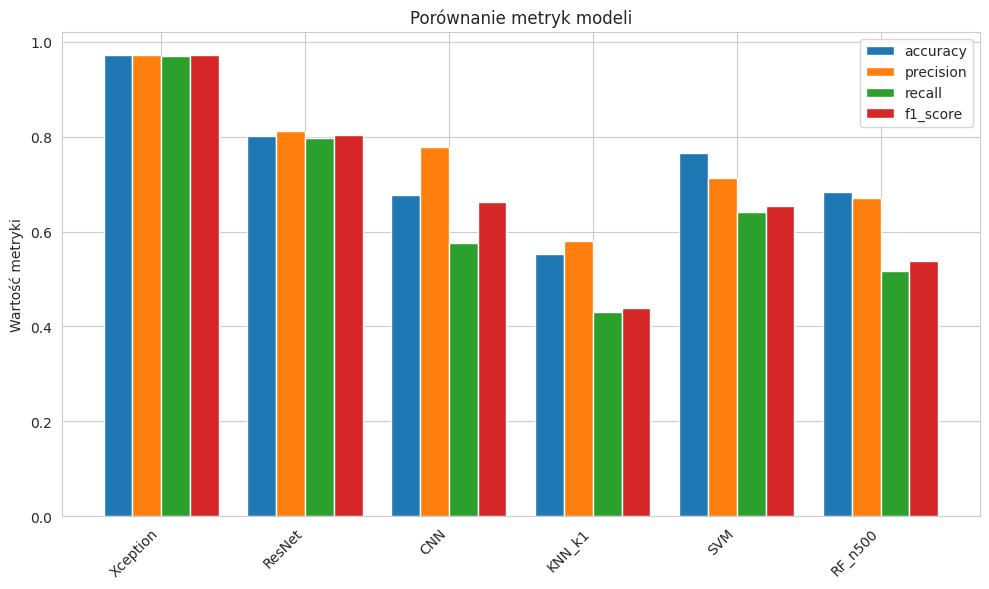

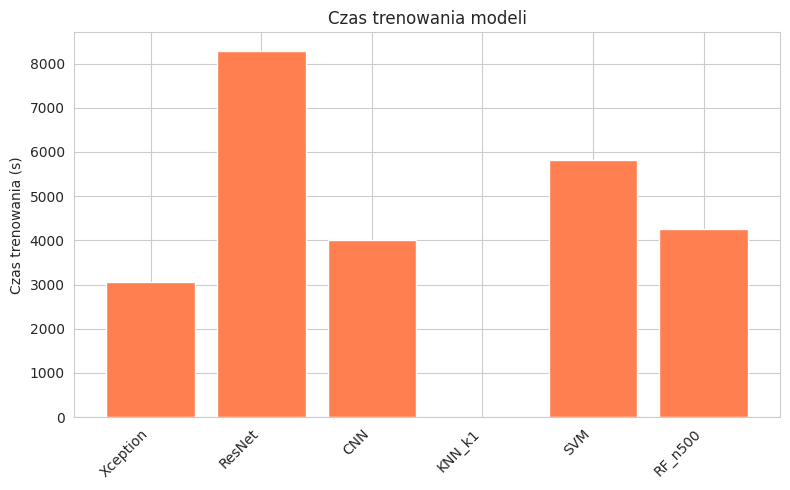

In [ ]:
# uzycie funkcji do agregacji wynikow, najpierw trzeba przeniesc metryki wybranych modeli do odpowiedniego katalogu

load_and_plot_all_results("/content/drive/MyDrive/praca_magisterska/wyniki/",
                          "/content/drive/MyDrive/praca_magisterska/wyniki/porownania/")

In [ ]:
# Funkcja: agregacja wyników dla roznych parametrow KNN

import glob
import pandas as pd

def load_and_plot_all_results_KNN(results_dir, output_dir):

    # Ładuje metryki z plików JSON, tworzy wykres porównawczy i zapisuje go.

    os.makedirs(output_dir, exist_ok=True)
    results = []

    for json_file in glob.glob(os.path.join(results_dir, '*_metrics.json')):
        model_name = os.path.basename(json_file).replace('_metrics.json', '')
        with open(json_file, 'r') as f:
            metrics = json.load(f)
        metrics['model'] = model_name
        results.append(metrics)

    df = pd.DataFrame(results)

    #print(df)

    """
    Tworzy wykres słupkowy porównujący accuracy, precision, recall i f1_score
    dla różnych modeli.

    Parameters:
    - df: pandas DataFrame zawierający metryki i kolumnę 'model'
    - output_path: jeśli podano, zapisuje wykres do pliku
    """
    output_path='porownanie_metryk.png'

    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    models = df['model']
    values = df[metrics]

    x = range(len(models))
    bar_width = 0.2
    offset = [-1.5, -0.5, 0.5, 1.5]  # przesunięcia słupków względem pozycji modelu

    plt.figure(figsize=(10, 6))

    for i, metric in enumerate(metrics):
        plt.bar([pos + bar_width * offset[i] for pos in x],
                df[metric],
                width=bar_width,
                label=metric)

    plt.xticks(x, models, rotation=45, ha='right')
    plt.ylabel('Wartość metryki')
    plt.title('Porównanie metryk modelu KNN dla różnych wartości n_neighbors')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"porowonanie metryk modelu KNN dla różnych wartości n_neighbors.png"))
    plt.show()

    # czasy trenowania

    plt.figure(figsize=(8, 5))
    plt.bar(df['model'], df['training_time (s)'], color='coral')
    plt.ylabel('Czas trenowania (s)')
    plt.title('Czas trenowania modelu KNN dla różnych wartości n_neighbors')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"porowonanie czasów trenowania modelu KNN dla różnych wartości n_neighbors.png"))
    plt.show()


In [ ]:
# Funkcja: agregacja wyników dla roznych parametrow KNN wykres LINIOWY

import glob
import pandas as pd

def load_and_plot_all_results_KNN_linear(results_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    results = []

    for json_file in glob.glob(os.path.join(results_dir, '*_metrics.json')):
        model_name = os.path.basename(json_file).replace('_metrics.json', '')
        with open(json_file, 'r') as f:
            metrics = json.load(f)
        metrics['model'] = model_name
        results.append(metrics)

    df = pd.DataFrame(results)

    # Posortuj po nazwie modelu, np. KNN_k=3, KNN_k=5, ...
    df = df.sort_values(by='model')

    # Wykres metryk - LINIowy
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    x = df['model']

    plt.figure(figsize=(10, 6))

    for metric in metrics:
        plt.plot(x, df[metric], marker='o', label=metric)

    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Wartość metryki')
    plt.title('Porównanie metryk modelu KNN dla różnych wartości n_neighbors')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "porownanie_metryk_liniowy.png"))
    plt.show()

    # Wykres czasu trenowania - LINIowy
    plt.figure(figsize=(8, 5))
    plt.plot(x, df['training_time (s)'], marker='o', color='coral')
    plt.ylabel('Czas trenowania (s)')
    plt.title('Czas trenowania modelu KNN dla różnych wartości n_neighbors')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "porownanie_czasu_trenowania_liniowy.png"))
    plt.show()


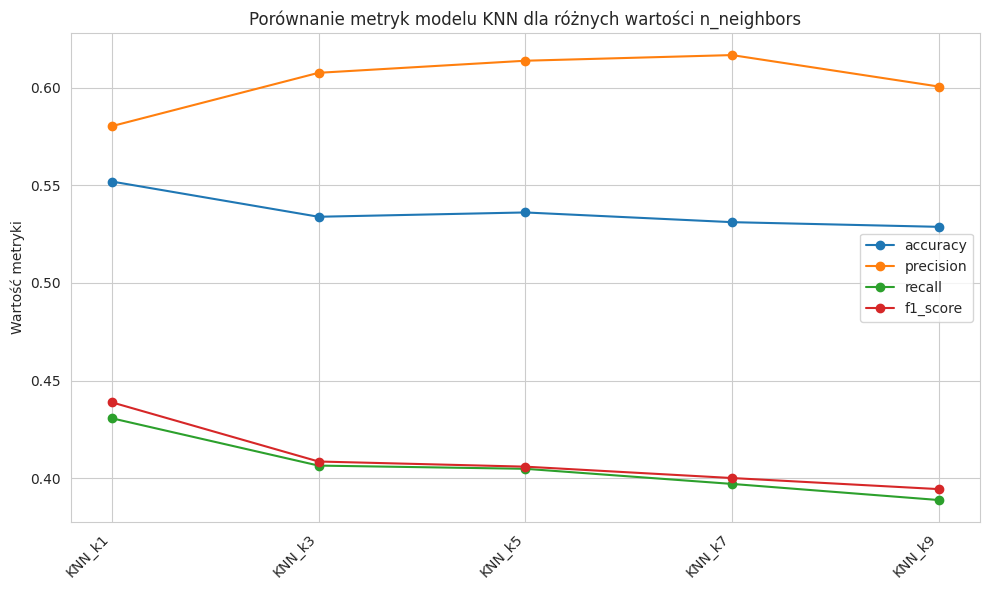

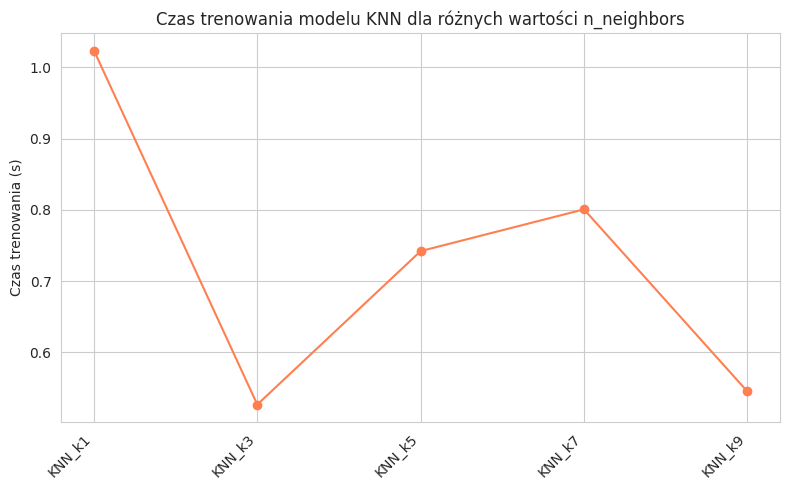

In [ ]:
# uzycie funkcji do agregacji wynikow dla modelu KNN z roznymi wartosciami n_neighbors

#load_and_plot_all_results_KNN("/content/drive/MyDrive/praca_magisterska/wyniki/KNN/",
#                          "/content/drive/MyDrive/praca_magisterska/wyniki/KNN")

load_and_plot_all_results_KNN_linear("/content/drive/MyDrive/praca_magisterska/wyniki/KNN/",
                          "/content/drive/MyDrive/praca_magisterska/wyniki/KNN")

In [ ]:
# Zbieranie metryk końcowych
metrics_summary = {
    'Xception': xception_metrics,
    'ResNet50': resnet_metrics,
    'CNN': cnn_metrics,
    'KNN': knn_metrics,
    'SVM': svm_metrics,
    'RF': rf_metrics
}


In [ ]:
# Tworzenie DataFrame i wykresu
metrics_df = pd.DataFrame(metrics_summary).T

# Wykres metryk (bez czasu trenowania)
plt.figure(figsize=(12, 8))
metrics_df.drop(columns=["training_time (s)"]).plot(kind='bar')
plt.title('Porównanie metryk modeli')
plt.ylabel('Wartość metryki')
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
print(metrics_df.drop(columns=["training_time (s)"]))

In [ ]:
print(metrics_df)

In [ ]:
# Wykres czasu trenowania
plt.figure(figsize=(8, 5))
metrics_df["training_time (s)"].plot(kind='bar', color='orange')
plt.title('Czas trenowania modeli (w sekundach)')
plt.ylabel('Czas [s]')
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()